In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, GRU

# Load data
df = pd.read_csv(r'C:\Users\dinhn\Downloads\Ethereum_Historical_Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))

# Function to create dataset for time series
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Set time step
time_step = 10

# Split data into train and test sets
train_size = int(0.7 * len(data_scaled))
test_size = len(data_scaled) - train_size
train_data, test_data = data_scaled[0:train_size,:], data_scaled[train_size:len(data_scaled),:1]

# Create dataset for training and testing
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

# Build the GRU model
model = Sequential()
model.add(GRU(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(GRU(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32, verbose=1)

# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred)

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)

print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")

Epoch 1/100
42/42 [==============================] - 5s 10ms/step - loss: 0.0213
Epoch 2/100
42/42 [==============================] - 0s 10ms/step - loss: 9.1742e-04
Epoch 3/100
42/42 [==============================] - 0s 11ms/step - loss: 7.6639e-04
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 7.1340e-04
Epoch 5/100
42/42 [==============================] - 1s 13ms/step - loss: 6.6785e-04
Epoch 6/100
42/42 [==============================] - 1s 12ms/step - loss: 6.2833e-04
Epoch 7/100
42/42 [==============================] - 0s 11ms/step - loss: 5.9125e-04
Epoch 8/100
42/42 [==============================] - 1s 18ms/step - loss: 5.9254e-04
Epoch 9/100
42/42 [==============================] - 1s 18ms/step - loss: 5.5593e-04
Epoch 10/100
42/42 [==============================] - 1s 14ms/step - loss: 5.4200e-04
Epoch 11/100
42/42 [==============================] - 1s 15ms/step - loss: 5.3253e-04
Epoch 12/100
42/42 [==============================] - 1s 14ms/step 

<h2> Predict Price for next 30 days </h2>

Predicted Ethereum prices for the next 30 days:
[3744.82190828 3680.41324551 3617.410478   3554.54051128 3493.27059795
 3434.06470026 3376.97913246 3321.95870098 3268.91851418 3217.75995205
 3168.39083853 3120.70638987 3074.61218863 3030.01914061 2986.84403519
 2945.01038584 2904.44702927 2865.08868576 2826.87539885 2789.75057409
 2753.66125929 2718.55926512 2684.39836346 2651.13708908 2618.73481728
 2587.15512589 2556.36271343 2526.32423964 2497.00972626 2468.39059591]


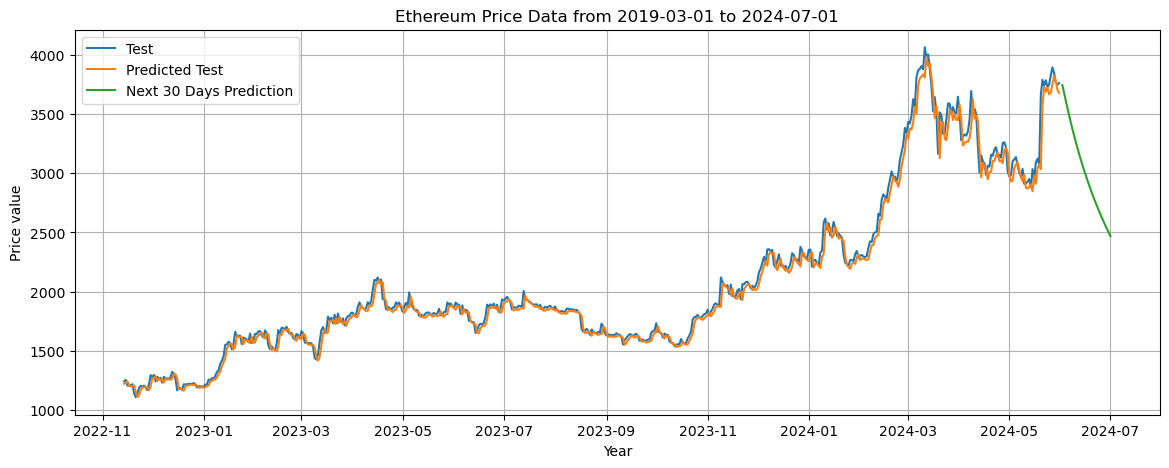

In [2]:
# The process of creating index to predict the next 90 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 90 days
lst_output = []
n_steps = time_step
i = 0
while(i < 30):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_30_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 90 days
print('Predicted Ethereum prices for the next 30 days:')
print(y_next_30_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 90 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_30_days, y_next_30_days, label='Next 30 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"Ethereum Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_30_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predicted Price for next 60 days


Predicted Ethereum prices for the next 60 days:
[3744.82190828 3680.41324551 3617.410478   3554.54051128 3493.27059795
 3434.06470026 3376.97913246 3321.95870098 3268.91851418 3217.75995205
 3168.39083853 3120.70638987 3074.61218863 3030.01914061 2986.84403519
 2945.01038584 2904.44702927 2865.08868576 2826.87539885 2789.75057409
 2753.66125929 2718.55926512 2684.39836346 2651.13708908 2618.73481728
 2587.15512589 2556.36271343 2526.32423964 2497.00972626 2468.39059591
 2440.43869147 2413.12851743 2386.43555886 2360.33740214 2334.81177372
 2309.83864141 2285.39867344 2261.47281823 2238.04398539 2215.09508451
 2192.61042604 2170.57502089 2148.97486051 2127.79523596 2107.02409991
 2086.64828436 2066.65588205 2047.0363866  2027.77803085 2008.87016832
 1990.30369348 1972.06880034 1954.15596313 1936.55677673 1919.26241577
 1902.26475531 1885.55609065 1869.12913737 1852.97689121 1837.09206774]


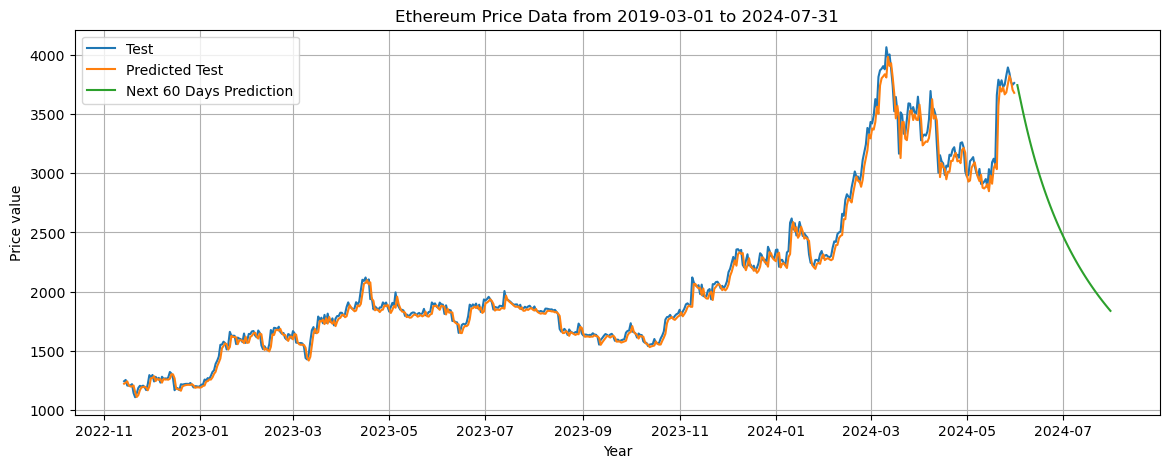

In [3]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 60):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_60_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted Ethereum prices for the next 60 days:')
print(y_next_60_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_60_days = pd.date_range(start=next_date, periods=60).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_60_days, y_next_60_days, label='Next 60 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"Ethereum Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_60_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()

<h2> Predict Price for the next 90 days </h2>

Predicted Ethereum prices for the next 90 days:
[3744.82190828 3680.41324551 3617.410478   3554.54051128 3493.27059795
 3434.06470026 3376.97913246 3321.95870098 3268.91851418 3217.75995205
 3168.39083853 3120.70638987 3074.61218863 3030.01914061 2986.84403519
 2945.01038584 2904.44702927 2865.08868576 2826.87539885 2789.75057409
 2753.66125929 2718.55926512 2684.39836346 2651.13708908 2618.73481728
 2587.15512589 2556.36271343 2526.32423964 2497.00972626 2468.39059591
 2440.43869147 2413.12851743 2386.43555886 2360.33740214 2334.81177372
 2309.83864141 2285.39867344 2261.47281823 2238.04398539 2215.09508451
 2192.61042604 2170.57502089 2148.97486051 2127.79523596 2107.02409991
 2086.64828436 2066.65588205 2047.0363866  2027.77803085 2008.87016832
 1990.30369348 1972.06880034 1954.15596313 1936.55677673 1919.26241577
 1902.26475531 1885.55609065 1869.12913737 1852.97689121 1837.09206774
 1821.46794286 1806.09779248 1790.97587312 1776.09644127 1761.45333319
 1747.04108555 1732.85423503 

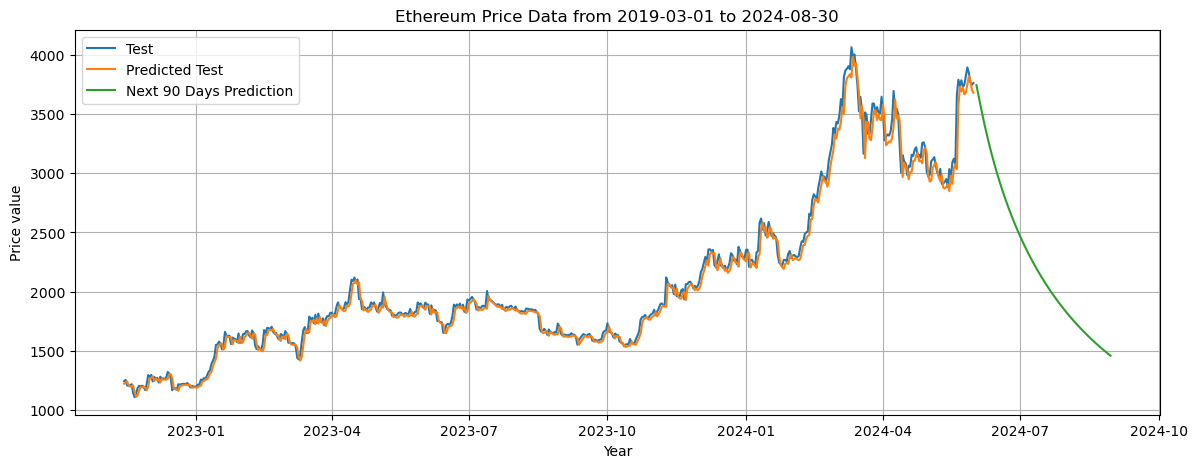

In [4]:
# The process of creating index to predict the next 60 days
last_index = len(df_Price) - 1

# Create an array of 90 consecutive integers starting from last_index
x_input = data_scaled[last_index-time_step:].reshape(1, -1)
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Predict the closing prices for the next 60 days
lst_output = []
n_steps = time_step
i = 0
while(i < 90):
    if(len(temp_input) > time_step):
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i = i + 1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i = i + 1

# Inverse transform the predicted values
y_next_90_days = scaler.inverse_transform(lst_output)

# Print the predicted closing prices for the next 60 days
print('Predicted Ethereum prices for the next 90 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)
# Create a list of indices starting from the next date for 60 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_test)], y_test, label='Test')
plt.plot(df.index[train_size + time_step:train_size + time_step + len(y_pred)], y_pred, label='Predicted Test')
plt.plot(index_next_90_days, y_next_90_days, label='Next 90 Days Prediction')
plt.legend()
plt.grid()
plt.title(f"Ethereum Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()